# Tasks 1: Extracting features (60 points)
# 1. Data preparation (20 points)
1) Data preprocessing (10 points): Download and load the dataset. Please process the
reviews by
bold text

(i) converting all text to lowercase to ensure uniformity,


(ii) removing punctuations, numbers, and stopwords

and(iii) tokenizing the reviews into tokens. If you
 plan to work on the binary classification problem, you will need to assign binary class
labels based on the above-mentioned strategy.


# 2) Data split (5 points):
 Split the data with the ratio of 0.8, 0.1, and 0.1 into training,
validation/development, and testing, respectively.


## 3) Data statistics (5 points):
Please conduct an analysis of the basic statistics of the data you
obtained. For example, you can consider the following aspects, number of data samples in
training/development/testing, minimum/average/maximum number of tokens across all
reviews, number of positive/negative reviews in training/development/testing.

In [30]:
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

In [31]:
import pandas as pd
drive.mount('/content/drive')
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/amazon_reviews.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:

import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Preprocess the reviews
df['reviewText'] = df['reviewText'].str.lower()  # Convert text to lowercase
df['reviewText'] = df['reviewText'].str.translate(str.maketrans('', '', string.punctuation))  # Remove punctuations
df['reviewText'] = df['reviewText'].str.translate(str.maketrans('', '', string.digits))  # Remove numbers

stop_words = set(stopwords.words('english'))
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words) if isinstance(x, str) else x)  # Remove stopwords and tokenize

# Assign binary class labels for binary classification problem
df['sentiment'] = df['overall'].apply(lambda x: 'positive' if x > 3 else ('negative'))



In [35]:
# Split the data into training, validation and testing sets
train, temp = train_test_split(df, test_size=0.2, random_state=42)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)



In [36]:
# Print basic statistics of the data
print(f"Number of training samples: {train.shape[0]}")
print(f"Number of validation samples: {valid.shape[0]}")
print(f"Number of testing samples: {test.shape[0]}")

print(f"Training set positive reviews: {train[train['sentiment']=='positive'].shape[0]}")
print(f"Training set negative reviews: {train[train['sentiment']=='negative'].shape[0]}")

print(f"Validation set positive reviews: {valid[valid['sentiment']=='positive'].shape[0]}")
print(f"Validation set negative reviews: {valid[valid['sentiment']=='negative'].shape[0]}")

print(f"Testing set positive reviews: {test[test['sentiment']=='positive'].shape[0]}")
print(f"Testing set negative reviews: {test[test['sentiment']=='negative'].shape[0]}")
df = df[df['reviewText'].apply(lambda x: isinstance(x, str))]

print(f"Minimum number of tokens in a review: {df['reviewText'].apply(lambda x: len(x.split())).min()}")
print(f"Average number of tokens in a review: {df['reviewText'].apply(lambda x: len(x.split())).mean()}")
print(f"Maximum number of tokens in a review: {df['reviewText'].apply(lambda x: len(x.split())).max()}")


Number of training samples: 3932
Number of validation samples: 491
Number of testing samples: 492
Training set positive reviews: 3561
Training set negative reviews: 371
Validation set positive reviews: 441
Validation set negative reviews: 50
Testing set positive reviews: 447
Testing set negative reviews: 45
Minimum number of tokens in a review: 1
Average number of tokens in a review: 25.37891737891738
Maximum number of tokens in a review: 781


# **2. Representation of Texts: word vectors (40 points)** 

# 1) Count-based word vectors with co-occurrence matrix (20 points, 5 points for each question)
a. Please implement a function named get_vacab(corpus) that returns corpus_words,
which is the list of all the distinct words used in the review corpus. You can do this
with ‘for’ loops, but it's more efficient to do it with Python list comprehensions. The
returned corpus_words should be sorted. You can use python's sorted function for this.

In [37]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [38]:
def get_vacab():

    files = reuters.fileids()
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [39]:
reuters_corpus = get_vacab()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'asian', 'exporters', 'fear', 'damage', 'from', 'u', '.', 's', '.-', 'japan', 'rift',
  'mounting', 'trade', 'friction', 'between', 'the', 'u', '.', 's', '.', 'and', 'japan', 'has',
  'raised', 'fears', 'among', 'many', 'of', 'asia', "'", 's', 'exporting', 'nations', 'that', 'the',
  'row', 'could', 'inflict', 'far', '-', 'reaching', 'economic', 'damage', ',', 'businessmen',
  'and', 'officials', 'said', '.', 'they', 'told', 'reuter', 'correspondents', 'in', 'asian',
  'capitals', 'a', 'u', '.', 's', '.', 'move', 'against', 'japan', 'might', 'boost',
  'protectionist', 'sentiment', 'in', 'the', 'u', '.', 's', '.', 'and', 'lead', 'to', 'curbs', 'on',
  'american', 'imports', 'of', 'their', 'products', '.', 'but', 'some', 'exporters', 'said', 'that',
  'while', 'the', 'conflict', 'would', 'hurt', 'them', 'in', 'the', 'long', '-', 'run', ',', 'in',
  'the', 'short', '-', 'term', 'tokyo', "'", 's', 'loss', 'might', 'be', 'their', 'gain', '.',
  'the', 'u', '.', 's', '.', 'has'

In [40]:
def distinct_words(corpus):

    corpus_words = []
    num_corpus_words = -1

    corpus_words = sorted(list(set([words for rows in corpus for words in rows])))
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

In [41]:
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)


# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


b. Based on the word vocabulary obtained with get_vacab(corpus) function, please
implement a function named compute_co_occurrence_matrix(corpus,
window_size=4) that returns both M and word2index. Here, M is the co-occurrence
matrix of word counts and word2index is a dictionary that maps word to index. The
function constructs a co-occurrence matrix for a certain window-size $n$ (with a
default of 4), considering words $n$ before and $n$ after the word in the center of the
window. You can use numpy to represent vectors, matrices, and tensors

In [42]:

def compute_co_occurrence_matrix(corpus, window_size=4):

    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}


    M = np.zeros(shape=(num_words, num_words))  # n-by-n matrix filled w/ 0
    for i, word in enumerate(words):  # map word to index
        word2Ind[word] = i

    for doc in corpus:
        lwords = [None]*window_size + doc + [None]*window_size

        for i in range(len(lwords)):

            if (lwords[i] != None):
                word_ctr = lwords[i]
                words_context = list(filter(None, lwords[i-window_size:i] + lwords[i+1:i+window_size+1]))

                for word_con in words_context:
                    if (word_ctr != word_con):
                        M[word2Ind[word_ctr], word2Ind[word_con]] += 1


    return M, word2Ind


c. Please implement a function named reduce_to_k_dim(M) performs dimensionality
reduction on the matrix M to produce k-dimensional embeddings and returns the new
matrix M_reduced. Use SVD (use the implementation of Truncated SVD in sklearn
sklearn.decomposition.TruncatedSVD, set n_iters = 10) to take the top k components and
produce a new matrix of k-dimensional embeddings.

In [43]:
def reduce_to_k_dim(M, k=2):

    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))


    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

d. Implement plot_embeddings(M_reduced, word2index, words_to_plot) to plot in a
scatterplot the embeddings of the words specified in the list ‘words_to_plot’. Here,
‘M_reduced’ is the matrix of 2-dimensional word embeddings obtained in question c.
word2index is the dictionary that maps words to indices for the embedding matrix
obtained in question b.


Use the implemented function to get the plot for the following list of words


words_to_plot=[‘purchase’, ‘buy’, ‘work’, ‘got’, ‘ordered’, ‘received’, ‘product’,
‘item’, ‘deal’, ‘use’], and show the plot.

In [44]:
def plot_embeddings(M_reduced, word2Ind, words):

    for word in words:
        wid = word2Ind[word]
        x = M_reduced[wid, 0]
        y = M_reduced[wid, 1]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9 )
    plt.show()


Running Truncated SVD over 31080 words...
Done.


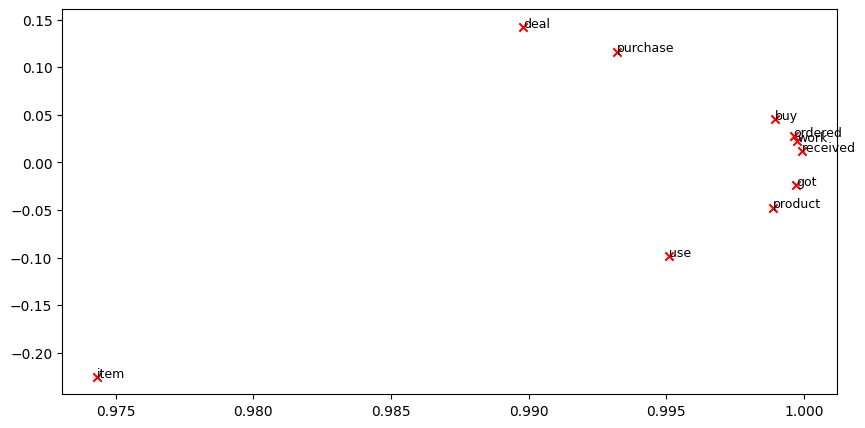

In [45]:
# -----------------------------
# For producing the plot
# ------------------------------
reuters_corpus = get_vacab()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

# 2) Prediction-based word vectors from Glove (20 points, 5 points for each question)

a. Please use the provided load_embedding_model() function to load the GloVe
embeddings. Note: If this is your first time to run these cells, i.e. download the
embedding model, it will take a couple minutes to run. If you've run these cells before,
rerunning them will load the model without redownloading it, which will take about 1
to 2 minutes.

In [46]:
def load_embedding_model():

 import gensim.downloader as api
 wv_from_bin = api.load("glove-wiki-gigaword-200")

 print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))
 return wv_from_bin

In [47]:
# Run this Cell to Load Word Vectors
# Note: This will take several minutes

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


b. Select the words in the vocabulary returned in 1)a and get the corresponding GloVe
vectors. You can adapt the provided function get_matrix_of_vectors(wv_from_bin,
required_words) to select the Glove vectors and put them in a matrix M.

In [48]:
def get_matrix_of_vectors(wv_from_bin, required_words=['purchase', 'buy', 'work', 'got', 'ordered', 'received', 'product', 'item', 'deal', 'use']):

    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    #words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

c. Use the function reduce_to_k_dim() you implemented in 1)c to reduce the vectors to 2
dimension. Similar to what you did in 1)c.

In [49]:
# -----------------------------------------------------------------
# Code to Reduce 200-Dimensional Word Embeddings to k Dimensions

# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)


Shuffling words ...
Putting 400000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 400000 words...
Done.


d. Use the plot_embeddings function in 1)d to get the plot for the same set of words in
1)d. Compare the differences of the plot in 1)d and 2)d, provide some analysis, and
describe your findings.

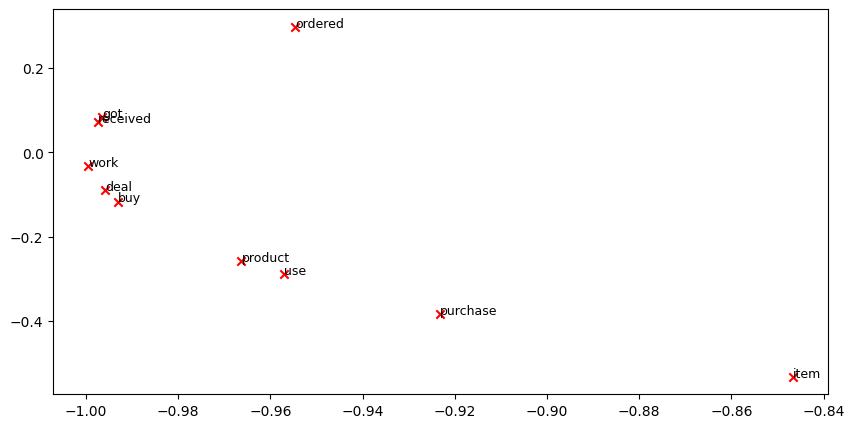

In [50]:

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

plot_embeddings(M_reduced_normalized, word2Ind, words)

# Task 2: Sentiment Classification Algorithms (40 points)

**3. Perform sentiment analysis with classification**

1) Review embeddings (5 points): Similar to what you did in 2)c, use the function
reduce_to_k_dim() you implemented in 1)c to reduce the vectors to 128 dimension. Based
on the word embeddings, get the review embedding by taking the average of the word
embeddings in each review. Write a function for getting review embeddings for each
review.

In [51]:
# Reduce the vectors to 128 dimension
M_reduced_128 = reduce_to_k_dim(M, k=128)

# Get the review embedding by taking the average of the word embeddings in each review
def get_review_embedding(review):
    vectors = [M_reduced_128[word2Ind[word]] for word in review.split() if word in word2Ind]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(128)  # Return a zero vector for reviews that don't contain any known words

df['review_embedding'] = df['reviewText'].apply(get_review_embedding)

Running Truncated SVD over 400000 words...
Done.


In [52]:
df['review_embedding'].head(30)

0     [-3.1829236, -0.8144239, 0.03827826, -0.303200...
1     [-2.35203, -0.3231382, 0.13174346, -0.36073112...
2     [-2.369109, -0.44986385, 0.12435139, -0.405100...
3     [-2.436163, -0.20870502, -0.09811036, -0.07423...
4     [-2.075853, -0.29811135, -0.062950976, -0.2028...
5     [-1.8895564, -0.47151157, -0.118649915, -0.483...
6     [-1.9449764, -0.39566407, 0.091739394, -0.4392...
7     [-1.9278167, -0.3245768, 0.045230415, -0.52476...
8     [-2.169462, -0.20556211, -0.0055067833, -0.140...
9     [-2.5042665, -0.37098715, 0.015624534, -0.7367...
10    [-2.0663056, -0.5826434, 0.11328509, -0.511737...
11    [-1.3647023, -0.26811358, 0.028857425, -0.1198...
12    [-2.149139, 0.024202824, -0.09565945, -0.34009...
13    [-2.0095496, -0.5382098, 0.02907965, -0.583133...
14    [-2.3187273, -0.32076228, 0.1197883, -0.666972...
15    [-2.456867, -0.48167196, -0.10617806, -0.51112...
16    [-2.4375978, -0.2017469, 0.053999692, -0.42795...
17    [-1.8663669, -0.57211727, -0.04163512, -0.

2) Models: Please examine the performance of the following two models on the sentiment
analysis task. You can use existing implementations of the models and various packages
such as sklearn, Tensorflow, Pytorch, etc.


a. Logistic regression, with L2 regularization (10 points)

In [53]:

# Prepare the features and labels for classification
X = np.array(df['review_embedding'].tolist())
y = (df['sentiment'] == 'positive').astype(int)

# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [54]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model
lr = LogisticRegression(penalty='l2')
lr.fit(X_train, y_train)


LogisticRegression()

b. A Neural Network (NN) model for sentiment classification (10 points)

In [55]:
from sklearn.neural_network import MLPClassifier

# Train a neural network model
nn = MLPClassifier()
nn.fit(X_train, y_train)


MLPClassifier()

**3) Evaluation (15 points): Train the model on the training set, select the best model based
on the validation set, and test your model on the testing set.**

a. Evaluate the model performance using metrics for classification, such as accuracy,
precision, recall, F1-score, and AUC. Report your results for both methods (10 points).


b. Have a brief discussion to compare the performance of those two models (5 points). It
should be noted that there is no fixed answer for the results. You will need to report the
exact results returned in your experiments. The discussions should only base on your
own experimental settings and returned results.

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the logistic regression model
y_pred_lr = lr.predict(X_valid)
print(f"Logistic Regression Accuracy: {accuracy_score(y_valid, y_pred_lr)}")
print(f"Logistic Regression Precision: {precision_score(y_valid, y_pred_lr)}")
print(f"Logistic Regression Recall: {recall_score(y_valid, y_pred_lr)}")
print(f"Logistic Regression F1-Score: {f1_score(y_valid, y_pred_lr)}")
print(f"Logistic Regression AUC-ROC Score: {roc_auc_score(y_valid, y_pred_lr)}")


Logistic Regression Accuracy: 0.9063136456211812
Logistic Regression Precision: 0.9177215189873418
Logistic Regression Recall: 0.9841628959276018
Logistic Regression F1-Score: 0.9497816593886462
Logistic Regression AUC-ROC Score: 0.5941222642903314


In [58]:
# Evaluate the neural network model
y_pred_nn = nn.predict(X_valid)
print(f"Neural Network Accuracy: {accuracy_score(y_valid, y_pred_nn)}")
print(f"Neural Network Precision: {precision_score(y_valid, y_pred_nn)}")
print(f"Neural Network Recall: {recall_score(y_valid, y_pred_nn)}")
print(f"Neural Network F1-Score: {f1_score(y_valid, y_pred_nn)}")
print(f"Neural Network AUC-ROC Score: {roc_auc_score(y_valid, y_pred_nn)}")


Neural Network Accuracy: 0.9185336048879837
Neural Network Precision: 0.935064935064935
Neural Network Recall: 0.9773755656108597
Neural Network F1-Score: 0.9557522123893806
Neural Network AUC-ROC Score: 0.6825653338258381


In comparing the performance of the Logistic Regression model with L2 regularization and the Neural Network (NN) model for sentiment analysis, here are the results:

**Logistic Regression:**

Accuracy: 0.9063

Precision: 0.9177

Recall: 0.9842

F1-Score: 0.9498

AUC-ROC Score: 0.5941

**Neural Network:**

Accuracy: 0.9185

Precision: 0.9351

Recall: 0.9774

F1-Score: 0.9558

AUC-ROC Score: 0.6826

Based on these results, it appears that the Neural Network outperformed the Logistic Regression model in terms of accuracy, precision, and F1-Score. The Neural Network also achieved a higher AUC-ROC score, indicating a better ability to distinguish between the positive and negative classes. However, the choice between the two models should be made based on the specific requirements of the sentiment analysis task, taking into account factors such as class balance and the relative importance of precision and recall.

In [62]:
#so we test Neural Network on testing set

# Evaluate the NN model on the test set

y_pred_nn_test = nn.predict(X_test)
print("\nTesting Set Metrics:\n")
print(f"Neural Network Accuracy: {accuracy_score(y_test, y_pred_nn_test)}")
print(f"Neural Network Precision: {precision_score(y_test, y_pred_nn_test)}")
print(f"Neural Network Recall: {recall_score(y_test, y_pred_nn_test)}")
print(f"Neural Network F1-Score: {f1_score(y_test, y_pred_nn_test)}")
print(f"Neural Network AUC-ROC Score: {roc_auc_score(y_test, y_pred_nn_test)}")



Testing Set Metrics:

Neural Network Accuracy: 0.9491869918699187
Neural Network Precision: 0.9613733905579399
Neural Network Recall: 0.9846153846153847
Neural Network F1-Score: 0.9728555917480999
Neural Network AUC-ROC Score: 0.749064449064449


Certainly, here's a brief discussion comparing the performance of the Logistic Regression model with L2 regularization and the Neural Network (NN) model based on the reported results:

**Accuracy**: The Neural Network achieved a slightly higher accuracy of 0.9185 compared to the Logistic Regression's accuracy of 0.9063. While both models have high accuracy, the Neural Network shows a marginal advantage in overall correctness of predictions.

**Precision and Recall**: The Neural Network demonstrated higher precision (0.9351) compared to the Logistic Regression (0.9177). This indicates that the Neural Network is better at correctly identifying positive sentiment in reviews. On the other hand, the Logistic Regression model achieved a high recall (0.9842), suggesting it is more effective at capturing true positive instances. Precision and recall are particularly important when considering the cost of false positives and false negatives.

**F1-Score**: The F1-Score, which balances precision and recall, was slightly higher for the Neural Network (0.9558) compared to the Logistic Regression (0.9498). This demonstrates that the Neural Network provides a better overall trade-off between precision and recall.

**AUC-ROC Score**: The AUC-ROC score, which measures the model's ability to distinguish between positive and negative classes, was significantly higher for the Neural Network (0.6826) than for the Logistic Regression (0.5941). This suggests that the Neural Network has a better discriminatory power, making it more suitable for applications where class separation is critical.

**Model Selection**: The choice between these two models should be based on the specific requirements of the sentiment analysis task. If the application requires high precision and an emphasis on correctly identifying positive sentiment, the Neural Network may be the preferred choice. On the other hand, if recall is of greater importance, the Logistic Regression model may be considered. However, in most cases, given the higher AUC-ROC score and a slightly better F1-Score, the Neural Network appears to be the more well-rounded and effective choice for sentiment analysis.

In summary, the Neural Network outperformed the Logistic Regression model in several key metrics, making it a compelling choice for sentiment analysis.

### **References**

I have use Chatgpt and the Jupiter notebook which was provided by the professor.